In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabulate as tb
import seaborn as sns

In [ ]:
df = pd.read_csv('./../res/model_testing_feature_sets_results.csv')
print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))  

+----+---------------------+------------+--------------+----------------------------+------------+------------+-----------+-----------------------+------------------+
|    |   feature_set_index | features   |   repetition | first_prediction_correct   |   accuracy |   f1_score |   auc_roc | confusion_matrix      |   last epoch num |
|----+---------------------+------------+--------------+----------------------------+------------+------------+-----------+-----------------------+------------------|
|  0 |                   0 | ['Close']  |            0 | True                       |   0.540123 |   0.701403 |  0.511467 | [[0, 149], [0, 175]]  |               22 |
|  1 |                   0 | ['Close']  |            1 | True                       |   0.540123 |   0.701403 |  0.490738 | [[0, 149], [0, 175]]  |               26 |
|  2 |                   0 | ['Close']  |            2 | True                       |   0.509259 |   0.464646 |  0.516606 | [[96, 53], [106, 69]] |               22 

In [21]:
def calc_precision_recall(row):
    confusion_matrix = np.array(eval(row['confusion_matrix']))
    tn, fp, fn, tp = confusion_matrix.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 
    return precision, recall  

df['precision'] = 0.0
df['recall'] = 0.0
for index, row in df.iterrows():
    precision, recall = calc_precision_recall(row)
    df.at[index, 'precision'] = precision
    df.at[index, 'recall'] = recall
    
print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))
    

+----+---------------------+------------+--------------+----------------------------+------------+------------+-----------+-----------------------+------------------+-------------+----------+
|    |   feature_set_index | features   |   repetition | first_prediction_correct   |   accuracy |   f1_score |   auc_roc | confusion_matrix      |   last epoch num |   precision |   recall |
|----+---------------------+------------+--------------+----------------------------+------------+------------+-----------+-----------------------+------------------+-------------+----------|
|  0 |                   0 | ['Close']  |            0 | True                       |   0.540123 |   0.701403 |  0.511467 | [[0, 149], [0, 175]]  |               22 |    0.540123 | 1        |
|  1 |                   0 | ['Close']  |            1 | True                       |   0.540123 |   0.701403 |  0.490738 | [[0, 149], [0, 175]]  |               26 |    0.540123 | 1        |
|  2 |                   0 | ['Close']  

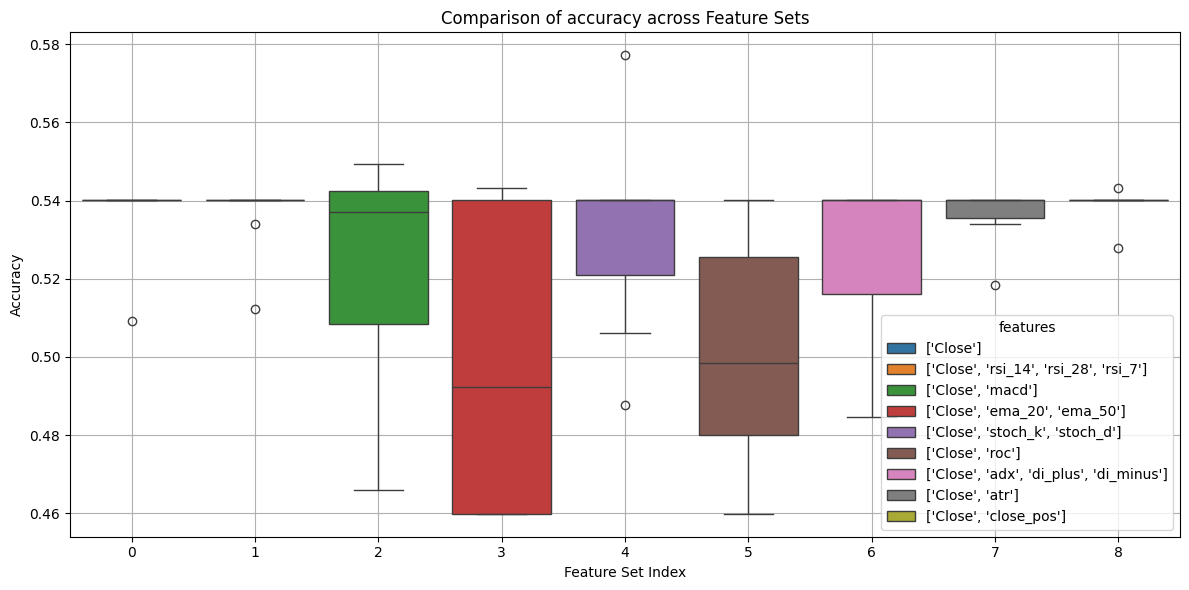

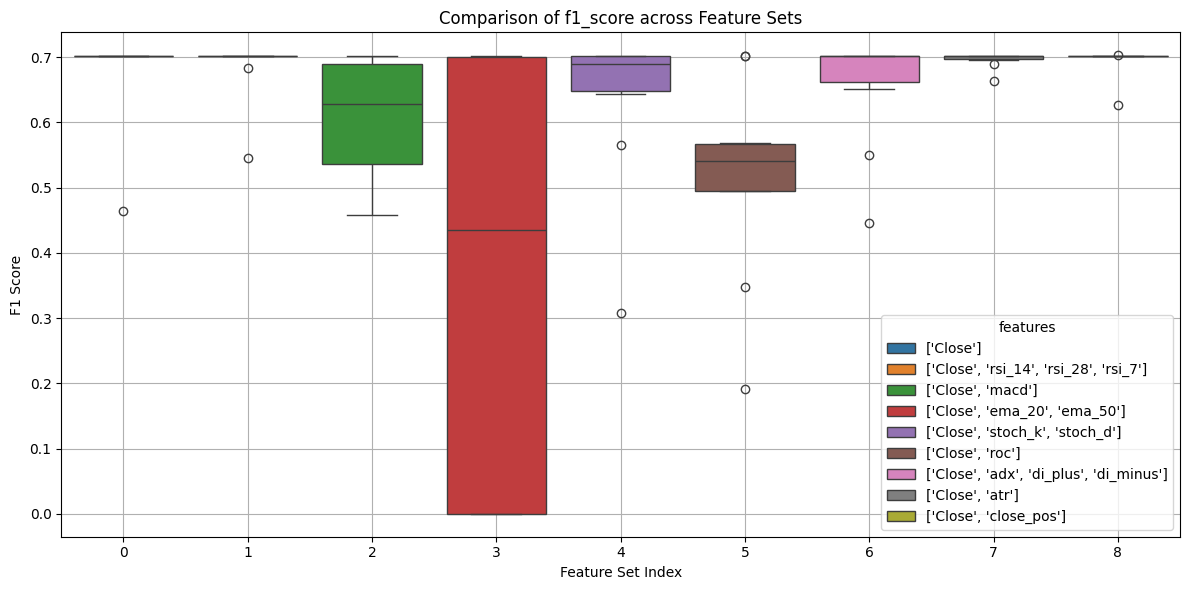

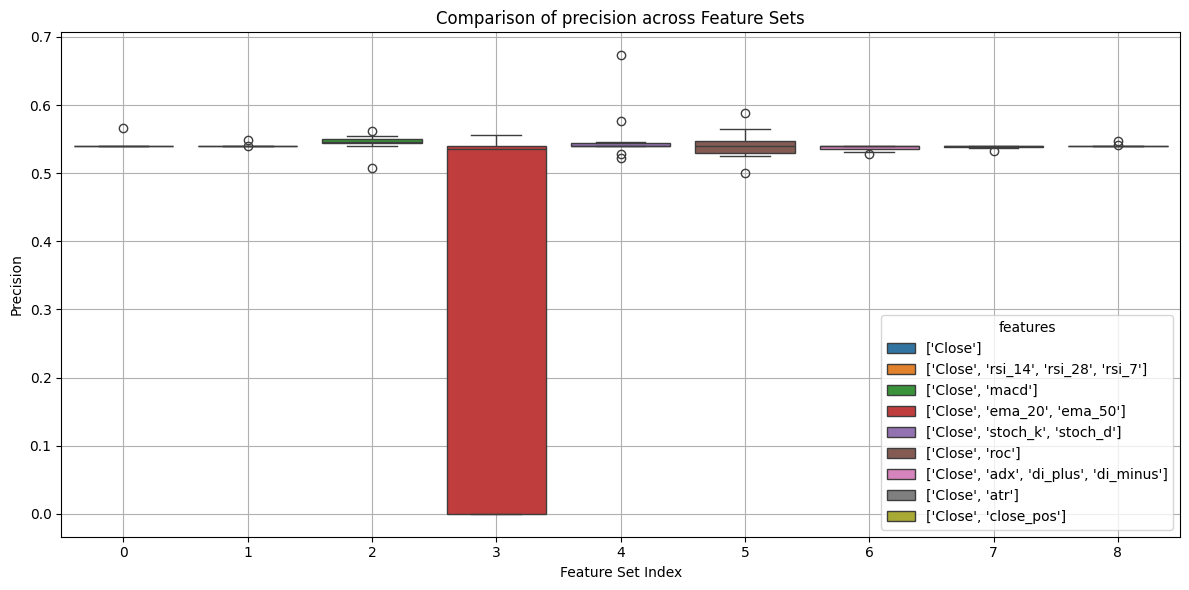

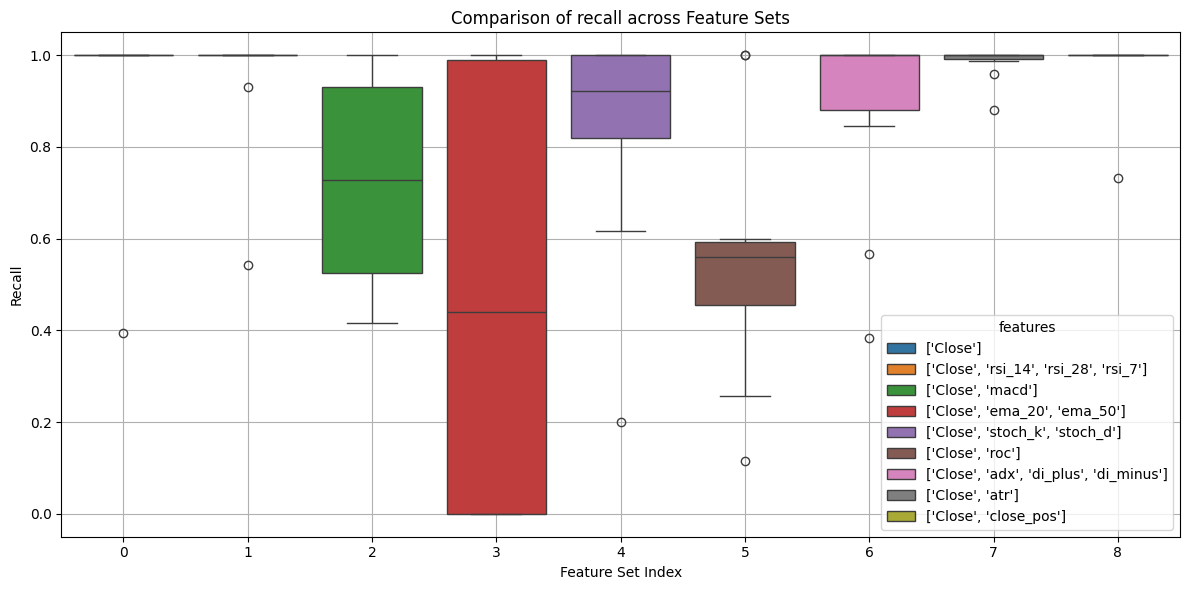

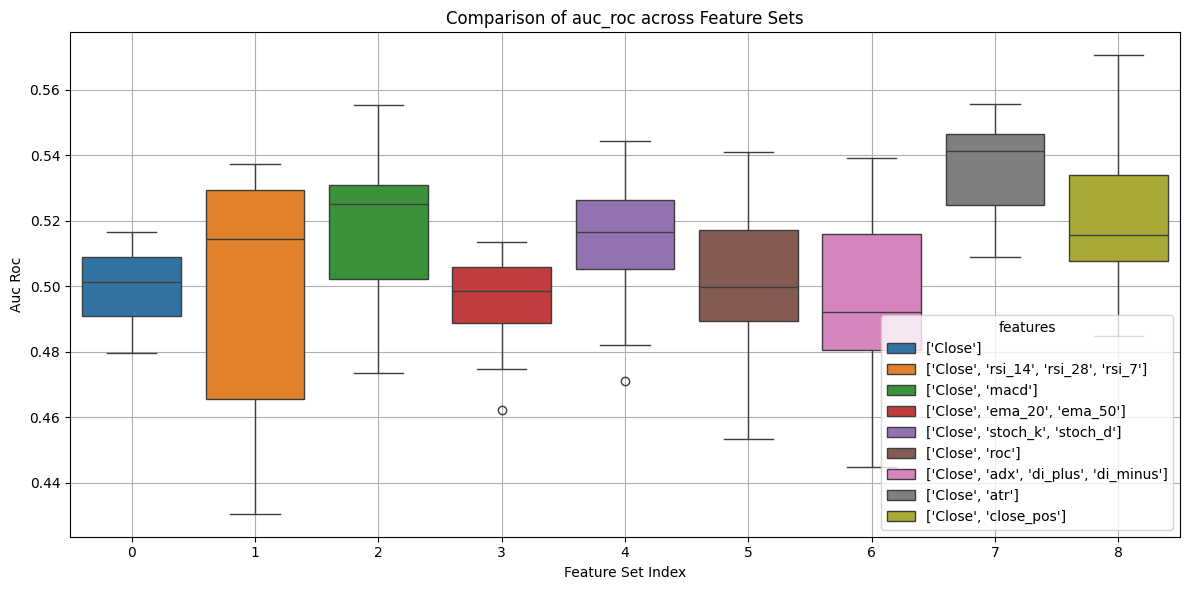

In [25]:
metrics = ["accuracy", "f1_score", "precision", "recall", "auc_roc"]
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='feature_set_index', y=metric, hue='features', data=df)
    plt.title(f'Comparison of {metric} across Feature Sets')
    plt.xlabel('Feature Set Index')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(title='features')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:
df_grouped = df.groupby(['feature_set_index']).agg(
    features_col=('features', 'first'),
    median_accuracy=('accuracy', 'median'),
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std'),
    avg_last_epoch_num=('last epoch num', 'mean')
).reset_index()


print(tb.tabulate(df_grouped, headers='keys', tablefmt='psql'))

#check each group woth shapiro
from scipy.stats import shapiro
for name, group in df.groupby('feature_set_index'):
    stat, p = shapiro(group['accuracy'])
    is_normal = p > 0.05
    print(f'Feature Set {name}: Statistics={stat:.3f}, p={p:.3f}, Normal={is_normal}')

+----+---------------------+-----------------------------------------+-------------------+-----------------+----------------+----------------------+
|    |   feature_set_index | features_col                            |   median_accuracy |   mean_accuracy |   std_accuracy |   avg_last_epoch_num |
|----+---------------------+-----------------------------------------+-------------------+-----------------+----------------+----------------------|
|  0 |                   0 | ['Close']                               |          0.540123 |        0.537037 |     0.00976012 |              19.7    |
|  1 |                   1 | ['Close', 'rsi_14', 'rsi_28', 'rsi_7']  |          0.540123 |        0.536728 |     0.0087841  |              19      |
|  2 |                   2 | ['Close', 'macd']                       |          0.537037 |        0.524691 |     0.0267885  |              23.4    |
|  3 |                   3 | ['Close', 'ema_20', 'ema_50']           |          0.492284 |        0.498765

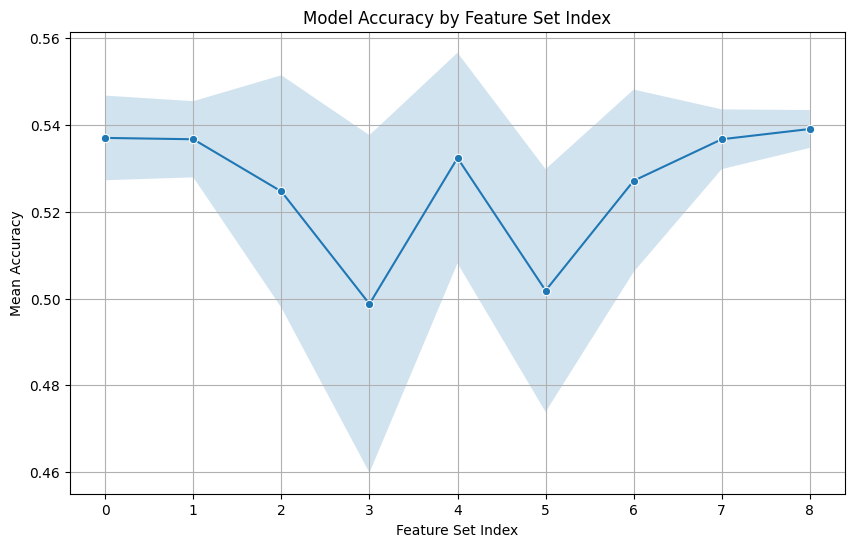

In [6]:

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='feature_set_index', y='mean_accuracy', marker='o')
plt.fill_between(
    df_grouped['feature_set_index'],
    df_grouped['mean_accuracy'] - df_grouped['std_accuracy'],
    df_grouped['mean_accuracy'] + df_grouped['std_accuracy'],
    alpha=0.2
)
plt.title('Model Accuracy by Feature Set Index')
plt.xlabel('Feature Set Index')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()